# <p style="text-align: center;"> Home work on Attentional LSTM network </p>
### <p style="text-align: center;"> Paul Peyssard </p>
### <p style="text-align: center;"> Worked in collaboration with Aglind Reka, Trang Nguyen, Matheus Paula </p>
#### <p style="text-align: center;"> MSc Data Science & Artificial Intelligence </p>
#### <p style="text-align: center;"> Intro to deep learning </p> 
#### <p style="text-align: center;"> 11/02/2023 </p>

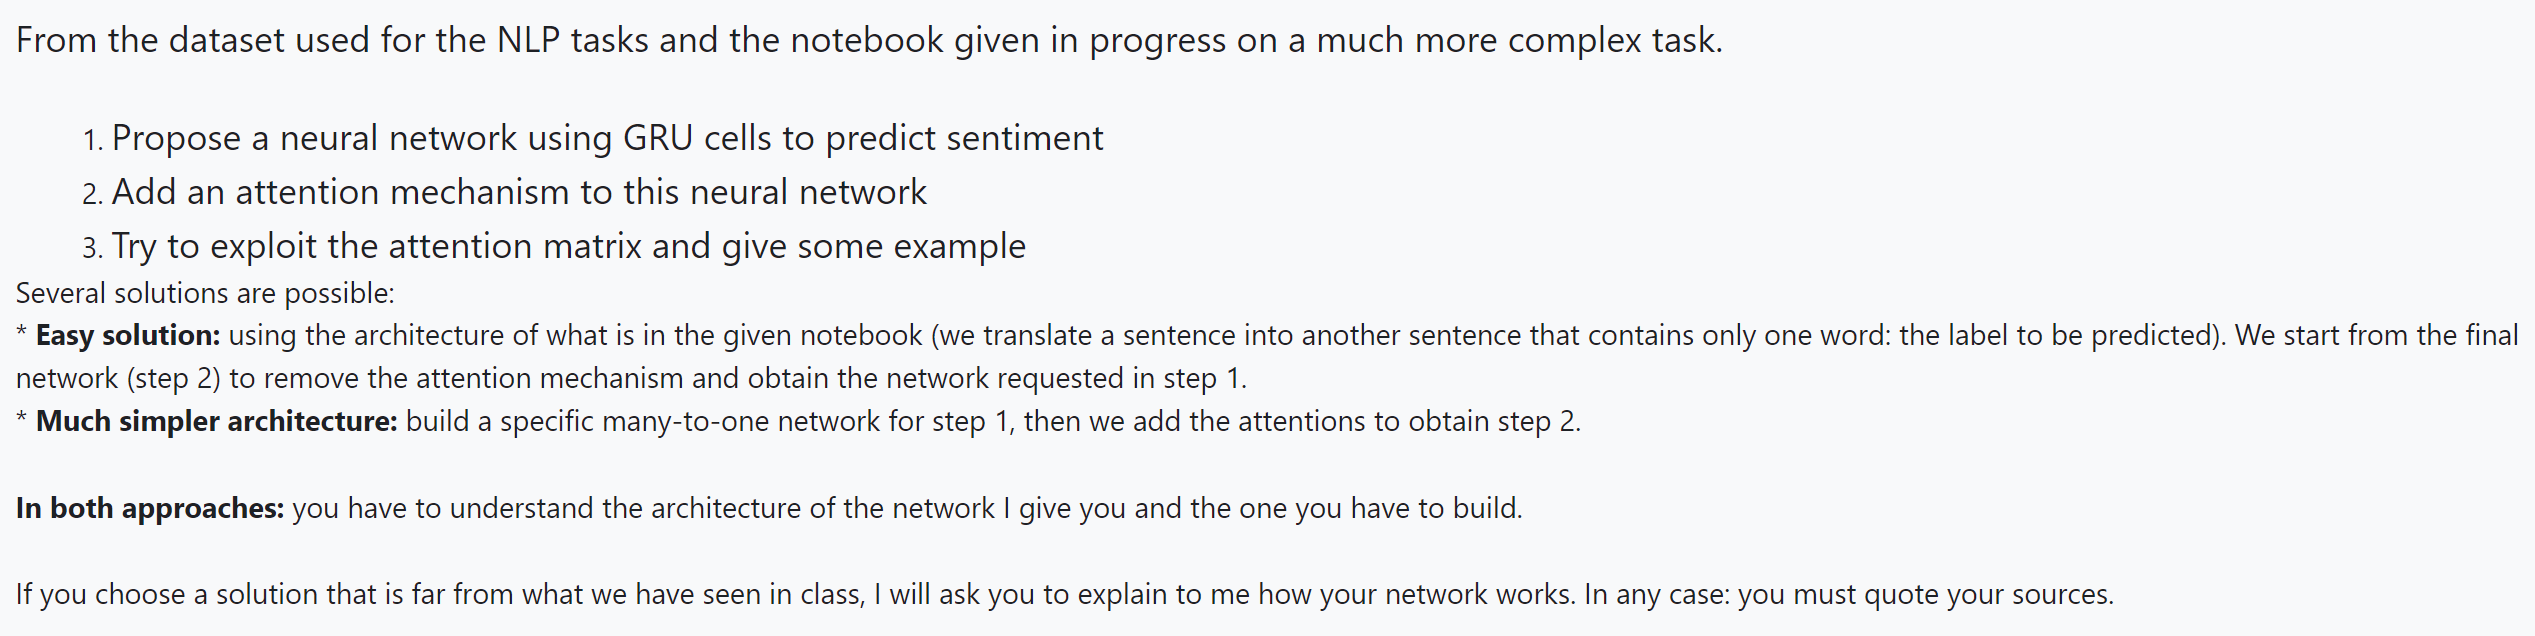

# Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, RMSprop


In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, f1_score,cohen_kappa_score

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import PorterStemmer

# Dataset

In [5]:
train = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
val = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
test = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

In [6]:
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)
print("Val shape : ",val.shape)

Train shape :  (5000, 6)
Test shape :  (1000, 6)
Val shape :  (1000, 6)


### a) Checking the data
I also checked the test and val but I did not want to overload the notebook

In [7]:
train.head(1)

Product Name Brand Name   Price  \
0  Samsung Galaxy Note 4 N910C Unlocked Cellphone...    Samsung  449.99   

   Rating                                 Reviews  Review Votes  
0       4  I love it!!! I absolutely love it!! üëåüëç           0.0

In [8]:
train.dtypes

Product Name     object
Brand Name       object
Price           float64
Rating            int64
Reviews          object
Review Votes    float64
dtype: object

Different classes

In [9]:
np.unique(train['Rating'])

array([1, 2, 3, 4, 5], dtype=int64)

### b) Build X (features vectors) and y (labels)

Keeping only reviews as features to work on sentiment analysis

For the label, as we want to predict sentiment, we use the rating in order to analyze the "rate" of the sentiment found in reviews

In [10]:
# Construct X_train and y_train
X_train = train['Reviews'].fillna("")
X_train = np.array(train['Reviews'].fillna("")).reshape(-1,1)
y_train = train['Rating']
y_train = np.array(train['Rating']).reshape(-1,1)
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [11]:
# Construct X_test and y_test
X_test = test['Reviews'].fillna("")
X_test = np.array(test['Reviews']).reshape(-1,1)
y_test = test['Rating']
y_test = np.array(test['Rating']).reshape(-1,1)
X_test.shape, y_test.shape

((1000, 1), (1000, 1))

In [12]:
# Construct X_val and y_val
X_val = val['Reviews'].fillna("")
X_val = np.array(val['Reviews']).reshape(-1,1)
y_val = val['Rating']
y_val = np.array(val['Rating']).reshape(-1,1)
X_val.shape, y_val.shape

((1000, 1), (1000, 1))

### c) Encode Ys

Vectorize the target feature

In [13]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_val_encoded = ohe.transform(y_val)
y_test_encoded = ohe.transform(y_test)

C:\Users\paul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### e) Text preprocessing

set the stopwords of english language

In [14]:
#nltk.download('stopwords')
#here you need to install all nltk packages if you use it on google colab
stops = set(stopwords.words('english'))

del_stops(text) is used to delete stop words

In [15]:
def del_stops(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stops:
            filtered_sentence.append(w)
    result=' '.join(filtered_sentence)
    return result

I tuned the step1 function from lab notebook_NLP_seq2seq-Spanish2English-with-Luong-attention in order to remove more emojis, non latin character and others.

In [16]:
# Process the data
import unicodedata

def step1(sent):
    # sent = on sentence in a language
    def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    sent = unicode_to_ascii(sent.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sent = re.sub(r"([?.!,¬ø])", r" \1 ", sent)
    sent = re.sub(r'[" "]+', " ", sent)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sent = re.sub(r"[^a-zA-Z?.!,¬ø]+", " ", sent)
    
    #removing emojis and non latin symbols (chinese, russian etc...)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    sent= re.sub(emoj, '', sent)
    
  
    return '<start> ' + sent.strip() + ' <end>' # and start and stop tag

clean_text(text) combine the previously implemented functions to lower the text, delete the stopwords, remove emojis and lemmatize the text

In [17]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
import re

def clean_text(text):
    text=text.lower() #lowercase the text
    #text=re.sub(r'[^\w\s]', '', text) #remove punctuation, voir si besoin de √ßa
    text=del_stops(text) #delete stop words
    text=lemmatizer.lemmatize(text)
    text=step1(text)
    return text

Applying clean_text() on train,test,val

The val set had one float element so I added astype(str) so it could run

In [18]:
X_train_p = np.array([clean_text(r) for r in X_train.flatten()])
X_test_p = np.array([clean_text(r) for r in X_test.flatten()])
X_val_p = np.array([clean_text(r) for r in X_val.flatten().astype(str)]) 

In [19]:
X_train_p[0]

'<start> love ! ! ! absolutely love ! ! <end>'

### Defining the babysit function in order to observe the learning curves of the models
babysit() is the same function we used several times in previous labs, it allows us to see the evolution of the learning curves

In [20]:
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

# Model

Some constant to build the model

In [21]:
BATCH_SIZE = 32
dropout=0.3
recurrent_size = 64 
nb_classes = 5
embedding_size = 20  
recurrent_size = 64  
hidden_size = recurrent_size // 4
dropout_rate = 0.2
learning_rate = 0.0075


Let's take only a small amount of data because it is a very large dataset.

I kept the cell but did not use it in the final model as it could run without.

In [22]:
# elements=4000
# X_train_p=X_train_p[0:elements]
# y_train_encoded=y_train_encoded[0:elements]

Call the function voc defined in previous lab in order to have the max length of vectorized array, the size of the vocab and and the number of words in the corpus

In [23]:
def voc(lang):
    lengths = [len(txt.split()) for txt in lang]
    vocab = set([w for txt in lang for w in txt.split()])  
    return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV

max_length_reviews, vocab_reviews, vocab_size_reviews = voc(X_train_p)
rate_size=5
print(max_length_reviews, vocab_size_reviews,rate_size)


704 8452 5


Build vectorize for the reviews (TextVectorization), it transforms the string in num vectors (output int) and build tokenized vocabulary

In [24]:
reviews_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size_reviews,
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=max_length_reviews,
)

reviews_vectorizer.adapt(X_train_p)


### Let's build the model

Input layer : take a 1D list of reviews as strings


In [25]:
inputLayer = layers.Input(shape=(1,), name="input", dtype=tf.string)

Transform the input (string) into a list of token using the predifined TextVectorization


In [26]:
vect = reviews_vectorizer(inputLayer)

Add an embedding layer to our NN, it maps each integer token to a dense vector, the sequences will be of the same size. 


In [27]:
embedding = layers.Embedding(
    input_dim=vocab_size_reviews,
    output_dim=embedding_size,
    weights=None,  # Without pre-learning
    trainable=True,  # Trainable
    name="embedding",
)(vect)

Uses a GRU layer as the RNN cells.
The GRU cell processes the sequences of input data by selectively updating and resetting its hidden state at each time step, allowing it to capture long-term dependencies in the input sequence.


recurrent_size is the number of hidden units

return_sequences=True : get an output for each time step in the sequence

return_state=False : Only return the output sequence
    
    

In [28]:
rnn = layers.GRU(
    recurrent_size,
    return_sequences=True,
    return_state=False,
    dropout=dropout_rate,
    recurrent_dropout=dropout_rate,
)(embedding)

Attention layer : 

The context vector generated by the GRU layer has a fixed size, which poses a significant limitation because the network is unable to retain information from lengthy sentences. For instance, processing the entire sequence can lead to the network forgetting the beginning of the sentence. To overcome this challenge, an attention mechanism can be employed.

The attention mechanism is a technique that aids a neural network in recollecting information from lengthy sequences by establishing a direct connection between the input and the context vector. The weights of the connection can be modified for each output, allowing the network to prioritize and focus on relevant parts of the input.


This line creates a Dense layer with 1 unit and tanh as the activation function. It maps the output of GRU to an attention score (a single one) for each time step in the input sequence.

In [29]:
attention = layers.Dense(1, activation="tanh")(rnn)

This line flattens the output of the previous Dense layer to a 1 dimension tensor. This is the probability distribution over the time steps of the GRU.

In [30]:
attention = layers.Flatten()(attention)

Softmax activation function applied to the previous tensor. It normalizes all the values to have a sum=1 and produce a new PDF over the time steps.
This new PDF will be used to create the weight of importance in every time steps.

In [31]:
attention = layers.Activation("softmax")(attention)

We didnt see RepeatVector in class but the idea of using it came from the following paper :

https://towardsdatascience.com/gru-recurrent-neural-networks-a-smart-way-to-predict-sequences-in-python-80864e4fe9f6

It is used to create a tensor with the shape (batch_size,timesteps,recurrent) by repeating the attention scores tensor  along the time step dimension.
This line and next line are made for the model to be able to do scalar multiplication

In [32]:
attention = layers.RepeatVector(recurrent_size)(attention)

This line is used to transpose the dimension of the tensor, it is necessary to ensure that the attention score are correctly aligned with the ouput of GRU layer when attention is applied to the output


In [33]:
attention = layers.Permute([2, 1])(attention)

Compute the dot product with layers.Dot between Gru and attzntion weights in order to have the final weighted sentence, the importance of each time step is determnied by the corresponding attention score.


In [34]:
sent_representation = layers.Dot(axes=1, normalize=False)([rnn, attention])

Flatten the output of the attention mechanism to put it in the next Dense layer

In [35]:
flatten = layers.Flatten()(sent_representation)


Then apply the dropout to prevent overfitting

In [37]:
hidden_dense = layers.Dropout(dropout_rate)(flatten)

Output layer of the model

In [38]:
outputLayer = layers.Dense(nb_classes, activation="softmax")(hidden_dense)


Create the model with its input and output

In [39]:
model = Model(inputs=inputLayer, outputs=outputLayer)

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 704)         0           ['input[0][0]']                  
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 704, 20)      169040      ['text_vectorization[0][0]']     
                                                                                                  
 gru (GRU)                      (None, 704, 64)      16512       ['embedding[0][0]']          

Initialize Early Stopping

In [41]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=5, restore_best_weights=True, verbose=1,
                                )]


Create an optimizer

In [42]:
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Compile the model

In [43]:
model.compile(optimizer=op, loss="categorical_crossentropy", metrics='accuracy')


Fit the model

In [44]:
history = model.fit(X_train_p,y_train_encoded,
                    validation_split=0.3,
                    epochs=4000, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/4000
110/110 [==============================] - 100s 857ms/step - loss: 1.3046 - accuracy: 0.5363 - val_loss: 1.2285 - val_accuracy: 0.5713
Epoch 2/4000
110/110 [==============================] - 94s 853ms/step - loss: 1.0278 - accuracy: 0.6443 - val_loss: 0.9772 - val_accuracy: 0.6500
Epoch 3/4000
110/110 [==============================] - 95s 861ms/step - loss: 0.7905 - accuracy: 0.7111 - val_loss: 0.9700 - val_accuracy: 0.6453
Epoch 4/4000
110/110 [==============================] - 96s 875ms/step - loss: 0.5914 - accuracy: 0.7791 - val_loss: 1.1778 - val_accuracy: 0.6253
Epoch 5/4000
110/110 [==============================] - 96s 873ms/step - loss: 0.4644 - accuracy: 0.8363 - val_loss: 1.4118 - val_accuracy: 0.5873
Epoch 6/4000
110/110 [==============================] - 98s 893ms/step - loss: 0.3636 - accuracy: 0.8746 - val_loss: 1.5212 - val_accuracy: 0.6253
Epoch 7/4000
110/110 [==============================] - 97s 879ms/step - loss: 0.2904 - accuracy: 0.9034 - val_loss: 

Babysit the model with the previously defined function

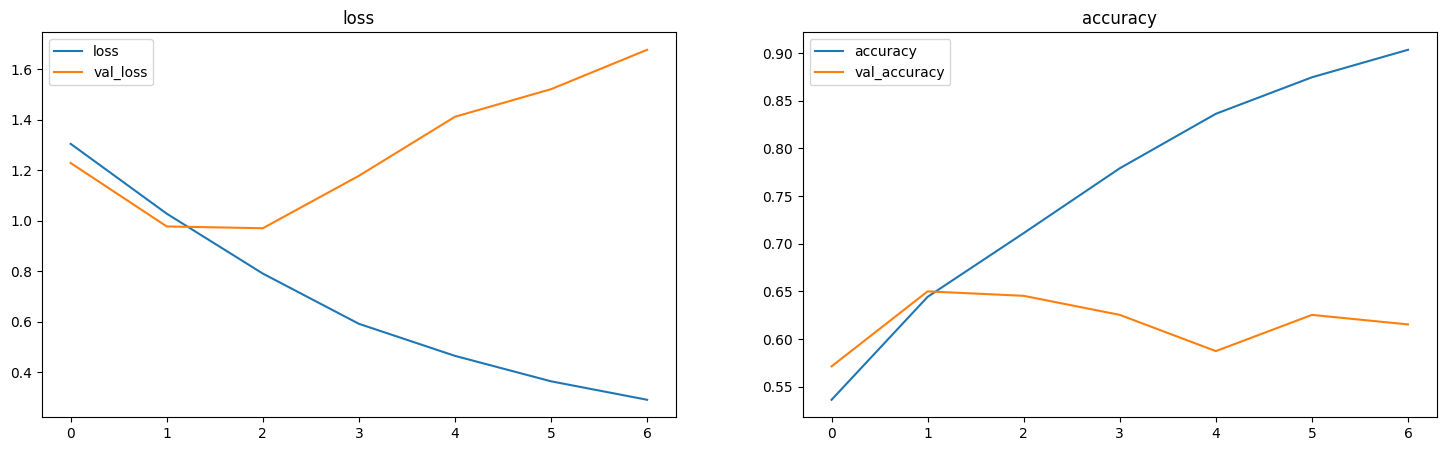

In [45]:
babysit(history.history)

Predict and plot the confusion matrix

157/157 [==============================] - 16s 100ms/step


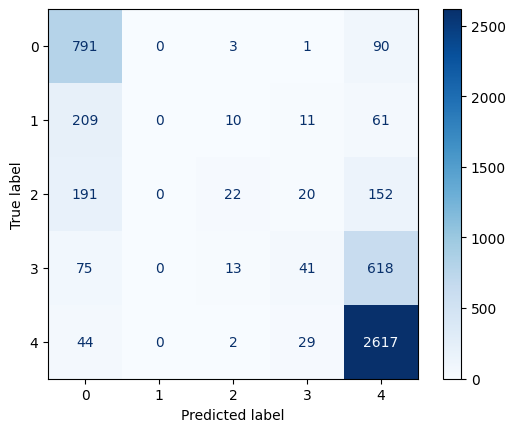

In [46]:
y_pred=model.predict(X_train_p)
ConfusionMatrixDisplay.from_predictions(y_train_encoded.argmax(1), y_pred.argmax(1), cmap="Blues")

# Conclusion : 

Building the model has not been easy and we had a lot of trouble with my group but we manage to adapt the attention principles to sentiment analysis.

On the training part, the model is learning very well and obtain an accuracy up to 90%, which is a very good thing, plus, the loss is decreasing a lot, another proof of learning.

On the over hand, we have a very bad val_loss and val_accuracy, we can see that the model is not learning very well for the validation part, the loss is even increasing.

The confusion matrix shows that we predict well the classes 0 and 4 only. However, after checking the train dataset, we can see that it is very unbalanced with a lot of 1 and 5 a few 2,3,4. 

In [55]:
print("Number of elements per class :\n","1 :",sum(y_train==1),
      "2 :",sum(y_train==2),
      "3 :",sum(y_train==3),
      "4 :",sum(y_train==4),
      "5 :",sum(y_train==5))

Number of elements per class :
 1 : [885] 2 : [291] 3 : [385] 4 : [747] 5 : [2692]


This unbalanced dataset can also be the cause of the of overifting that we have here.

In my opinion, the code can still be improved but the architecture is quite good. And as we worked a lot on this assignement, it allowed us to understand better the attention mechanism and go deeper in the comprehension of sentiment analysis and neural networks in general.